# Figure 3: Dendritic Target Propagation in Rate and Spiking Neurons

In [ ]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import torch

import EIANN as eiann
from EIANN import utils as ut
eiann.update_plot_defaults()
root_dir = ut.get_project_root()

<img src="diagrams/Fig3_DTP_scheme.png" width=800>

```{image} diagrams/Fig3_DTP_scheme.png
:alt: Diagram of Dend. Target Prop.
:class: bg-primary mb-1
:width: 1200px
:align: center
```

 Load pre-trained EIANN (DTP with weight symmetry)

In [2]:
network_name = "20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized"
network_seed = 66049
data_seed = 257
saved_network_path = root_dir + f"/EIANN/data/saved_network_pickles/mnist/{network_name}_{network_seed}_{data_seed}.pkl"
network = ut.load_network(saved_network_path)

param_history = network.param_history
param_history_steps = network.param_history_steps
sample_order = network.sample_order

train_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders(batch_size='full_dataset')
idx, data, target = next(iter(train_dataloader))

Loading network from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/data/saved_network_pickles/mnist/20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized_66049_257.pkl'
Network successfully loaded from '/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/data/saved_network_pickles/mnist/20240516_EIANN_2_hidden_mnist_BP_like_config_2L_complete_optimized_66049_257.pkl'


Compute activity dynamics from a saved checkpoint

In [3]:
saved_checkpoint = 30

# Load weights from a saved checkpoint halfway through training
state_dict = param_history[saved_checkpoint] 
print(f"Loaded network parameters from training step {param_history_steps[saved_checkpoint]}")

# Load the data sample and target label for the saved step
saved_step_idx = param_history_steps[saved_checkpoint]
sample_idx = sample_order[saved_step_idx]
data_sample = data[sample_idx]
target_sample = target[sample_idx]
print(f"Saved train step: {saved_step_idx}")
print(f"Data sample index: {sample_idx}")

# Create network object from config and load the weights
config_file_path = root_dir + f"/EIANN/network_config/mnist/{network_name}.yaml"
network = ut.build_EIANN_from_config(config_file_path, network_seed=network.seed)
network.load_state_dict(state_dict)

# Run a forward and backward pass to store dynamics
output = network.forward(data_sample, store_history=True, store_dynamics=True, no_grad=True)
network.update_forward_state(store_dynamics=True, store_history=True)
for backward in network.backward_methods:
    backward(network, output, target_sample, store_history=True, store_dynamics=True)

population = network.populations['H2E']
activity_dynamics_dict, dendrite_dynamics_dict = ut.compute_dendritic_state_dynamics(network)

# Crop to 10 time steps before/after the nudge timepoint
activity_dynamics_dict = {pop_name: activity[4:25] for pop_name, activity in activity_dynamics_dict.items()}
soma_activity = activity_dynamics_dict[population.fullname]
dendritic_state = dendrite_dynamics_dict[population.fullname][4:25]
before_nudge_idx = 10
after_nudge_idx = 11

Loaded network parameters from training step 2999
Saved train step: 2999
Data sample index: 30702


Plot somatic and dendritic dynamics for 2 example neurons

H2E example unit: (88, 51)


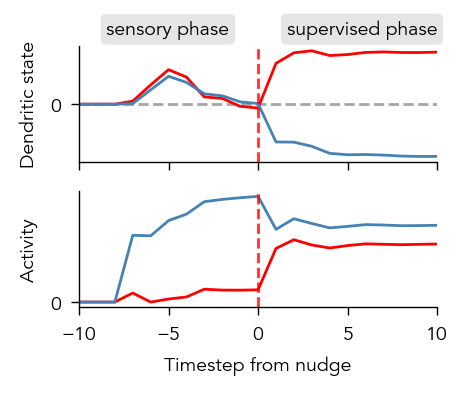

In [4]:
positive_unit_idx = 88
negative_unit_idx = 51
print(f"{population.fullname} example unit: {positive_unit_idx, negative_unit_idx}")

fig, axes  = plt.subplots(2,1,figsize=(2.35,2), height_ratios=[1,1], dpi=200)
ax1 = axes[0]
ax2 = axes[1]
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
time_from_nudge = np.arange(21)-10
ax1.plot(time_from_nudge, dendritic_state[:, positive_unit_idx], color='r', linewidth=1)
ax1.plot(time_from_nudge, dendritic_state[:, negative_unit_idx], color='steelblue', linewidth=1)
ax2.plot(time_from_nudge, soma_activity[:,positive_unit_idx], color='r', linewidth=1)
ax2.plot(time_from_nudge, soma_activity[:,negative_unit_idx], color='steelblue', linewidth=1)
ax1.axvline(0,0,1,color='r',linestyle='--', linewidth=1, alpha=0.8)
ax2.axvline(0,0,1,color='r',linestyle='--', linewidth=1, alpha=0.8)
ax1.set_ylabel('Dendritic state')
ax2.set_ylabel('Activity')
ax1.set_xticklabels([])
ax1.set_yticks([0])
ax2.set_yticks([0])
ax1.set_xlim(-10,10)
ax2.set_xlim(-10,10)
ax1.text(0.42, 1.1, 'sensory phase', transform=ax1.transAxes, ha='right', bbox=dict(facecolor='gray', alpha=0.2, boxstyle='round,pad=0.3', linewidth=0))
ax1.text(0.58, 1.1, 'supervised phase', transform=ax1.transAxes, ha='left', bbox=dict(facecolor='gray', alpha=0.2, boxstyle='round,pad=0.3', linewidth=0))
ax2.set_xlabel('Timestep from nudge')
plt.tight_layout()
plt.show()
fig.savefig(root_dir+f"/EIANN/figures/rate_dynamics_example_{population.fullname}.png", dpi=300)
fig.savefig(root_dir+f"/EIANN/figures/rate_dynamics_example_{population.fullname}.svg", dpi=300)

### Run spiking simulation

Convert presynaptic activations to spike rates and compute postsynaptic voltage dynamics in soma and dendrite compartments

In [5]:
print(f"{population.fullname} example units: {(positive_unit_idx, negative_unit_idx)}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Simulation parameters
time_coefficient = 20  # ms per time step
refractory_period = 1.  # ms

time_steps = soma_activity.shape[0] * time_coefficient
print(f"Simulation length: {time_steps} ms")

##################################################
# Convert RNN activations to Poisson rates (in Hz)
##################################################
weight_scale = 2.3
pre_spike_times = {}
pre_spikes = {}
soma_currents = {}
dend_currents = {}
eligibility_traces = {}

poisson_rates = {}
max_rate = 450.0  # Hz, scale factor for maximum firing rate
for projection in population:
    # Expand activity dynamics to match simulation time resolution, convert units to firing rates
    activity_dynamics_expanded = torch.tensor(scipy.ndimage.zoom(activity_dynamics_dict[projection.pre.fullname], (time_coefficient , 1), order=1))
    poisson_rates[projection.pre.fullname] = torch.clip(max_rate * activity_dynamics_expanded, 0, 1000/(refractory_period)) # Clip max rate to based on refractory period
    if projection.direction == 'R':
        poisson_rates[projection.pre.fullname] = torch.roll(poisson_rates[projection.pre.fullname], 1*time_coefficient, dims=0)
        poisson_rates[projection.pre.fullname][0:time_coefficient] *= 0

    # Generate Poisson spikes for presynaptic neurons
    num_neurons = poisson_rates[projection.pre.fullname].shape[1]
    pre_spike_times[projection.pre.fullname] = []
    pre_spikes[projection.pre.fullname] = torch.zeros((time_steps, num_neurons))
    for neuron_idx in range(num_neurons):
        unit_rate = poisson_rates[projection.pre.fullname][:, neuron_idx].numpy()
        unit_spike_times = ut.generate_inhomogeneous_poisson_spikes(unit_rate, refractory_period)
        pre_spike_times[projection.pre.fullname].append(unit_spike_times)
        if len(unit_spike_times) > 0:
            unit_spikes = scipy.signal.unit_impulse(time_steps, idx=unit_spike_times) # Convert spike times to binary spike train
            pre_spikes[projection.pre.fullname][:, neuron_idx] = torch.tensor(unit_spikes).type(torch.float32)

    # Compute input currents from presynaptic spikes
    input_currents = weight_scale * projection(pre_spikes[projection.pre.fullname]).numpy()
    if projection.compartment == 'dend':
        dend_currents[projection.pre.fullname] = input_currents
    else:
        soma_currents[projection.pre.fullname] = input_currents

H2E example units: (88, 51)
Simulation length: 420 ms


In [6]:
##################################################
# Main simulation loop
##################################################

# Neuron parameters
tau_neuron = network.tau * time_coefficient
tau_dend = time_coefficient
tau_ET = tau_neuron
print(f"Membrane time constant: {tau_neuron} ms")
print(f"Dendritic time constant: {tau_dend} ms")
print(f"Eligibility trace time constant: {tau_ET} ms")

# Initialize variables
v_membrane = torch.tensor([0., 0.])
v_dend = torch.tensor([0., 0.])
ET_values = {pre_pop: torch.zeros(spikes.shape[1]) for pre_pop,spikes in pre_spikes.items()}

soma_voltage_trace = {'positive_unit':[], 'negative_unit':[]}
dend_voltage_trace = {'positive_unit':[], 'negative_unit':[]}
eligibility_traces = {pre_pop: [] for pre_pop in pre_spikes}

for t in range(time_steps):
    total_dend_current = torch.tensor([0., 0.])
    for pre_pop in dend_currents:
        input_currents = dend_currents[pre_pop][t]
        total_dend_current[0] += input_currents[positive_unit_idx].sum().item()
        total_dend_current[1] += input_currents[negative_unit_idx].sum().item()

        delta_ET = -ET_values[pre_pop] + pre_spikes[pre_pop][t]*weight_scale
        ET_values[pre_pop] += delta_ET/tau_ET
        eligibility_traces[pre_pop].append(ET_values[pre_pop].clone())

    total_soma_current = torch.tensor([0., 0.])
    for pre_pop in soma_currents:
        input_currents = soma_currents[pre_pop][t]
        total_soma_current[0] += input_currents[positive_unit_idx].sum().item()
        total_soma_current[1] += input_currents[negative_unit_idx].sum().item()

        delta_ET = -ET_values[pre_pop]  + pre_spikes[pre_pop][t]*weight_scale
        ET_values[pre_pop] += delta_ET/tau_ET
        eligibility_traces[pre_pop].append(ET_values[pre_pop].clone())

    dvdt_dend = -v_dend + total_dend_current
    v_dend += dvdt_dend / tau_dend
        
    dvdt_soma = -v_membrane + total_soma_current + v_dend*3
    v_membrane += dvdt_soma / tau_neuron
    
    soma_voltage_trace['positive_unit'].append(v_membrane[0].item())
    soma_voltage_trace['negative_unit'].append(v_membrane[1].item())
    dend_voltage_trace['positive_unit'].append(v_dend[0].item())
    dend_voltage_trace['negative_unit'].append(v_dend[1].item())

eligibility_traces = {pre_pop: torch.stack(eligibility_traces[pre_pop]) for pre_pop in eligibility_traces}
soma_spikes_positive = ut.generate_inhomogeneous_poisson_spikes(np.clip(soma_voltage_trace['positive_unit'],0,None)*max_rate, refractory_period)
soma_spikes_negative = ut.generate_inhomogeneous_poisson_spikes(np.clip(soma_voltage_trace['negative_unit'],0,None)*max_rate, refractory_period)

##################################################
# Compare dW for rate and spiking models
##################################################
learning_rate = network.projections['H2E_H1E'].learning_rule.learning_rate
final_pre_activity = activity_dynamics_dict['H1E'][-1].type(torch.float32)
final_el_traces = eligibility_traces['H1E'][-1]

final_rate_dend =    {'positive_unit': dendritic_state[-1][positive_unit_idx].astype(np.float32),
                      'negative_unit': dendritic_state[-1][negative_unit_idx].astype(np.float32)}
final_spiking_dend = {'positive_unit': dend_voltage_trace['positive_unit'][-1],
                      'negative_unit': dend_voltage_trace['negative_unit'][-1]}
rate_dW =    {'positive_unit': final_pre_activity * final_rate_dend['positive_unit'] * learning_rate * bool(soma_activity[before_nudge_idx, positive_unit_idx] > 0),
              'negative_unit': final_pre_activity * final_rate_dend['negative_unit'] * learning_rate * bool(soma_activity[before_nudge_idx, negative_unit_idx] > 0)}
spiking_dW = {'positive_unit': final_el_traces * final_spiking_dend['positive_unit'] * learning_rate * bool(soma_activity[before_nudge_idx, positive_unit_idx] > 0),
              'negative_unit': final_el_traces * final_spiking_dend['negative_unit'] * learning_rate * bool(soma_activity[before_nudge_idx, negative_unit_idx] > 0)}

Membrane time constant: 60 ms
Dendritic time constant: 20 ms
Eligibility trace time constant: 60 ms


Plot spiking examples

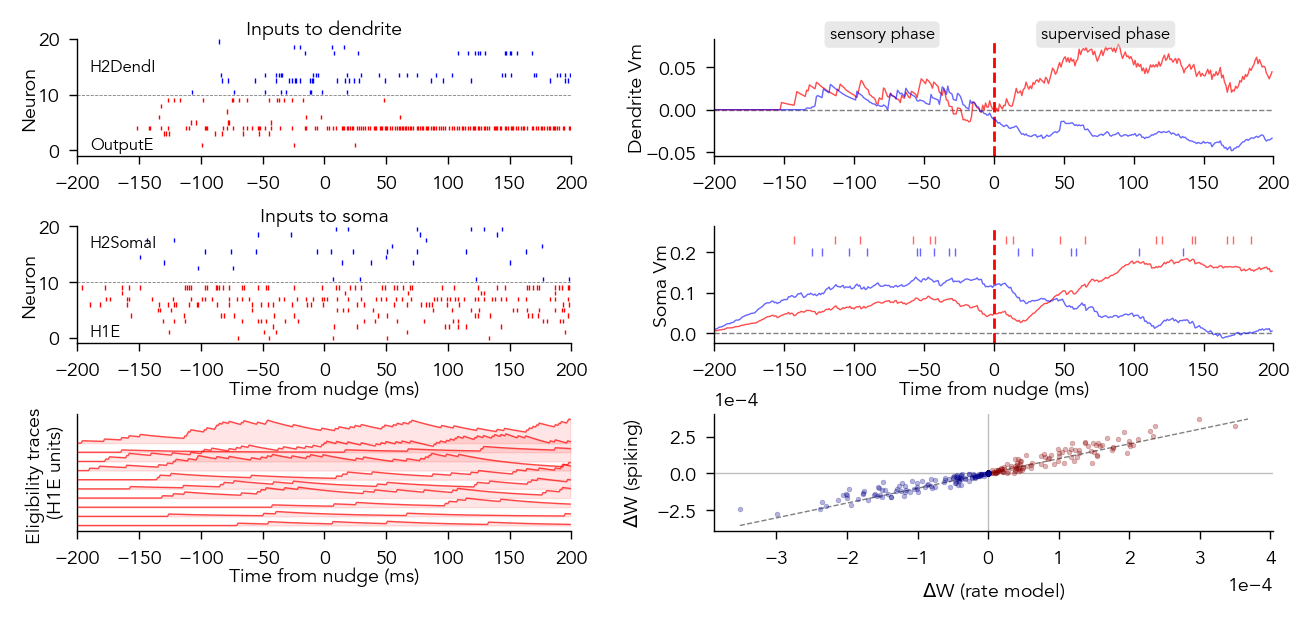

In [7]:
fig = plt.figure(figsize=(6.5, 3))
import matplotlib.gridspec as gs
axes_left = gs.GridSpec(3, 1, figure=fig, left=0.07, right=0.45, top=0.95, bottom=0.13, hspace=0.6, height_ratios=[1,1,1])
axes_right = gs.GridSpec(3, 1, figure=fig, left=0.56, right=0.99, top=0.95, bottom=0.13, hspace=0.6, height_ratios=[1,1,1])

nudge_time = np.ceil(soma_activity.shape[0]/2) * time_coefficient
time_axis = np.arange(time_steps) - nudge_time

# Dendritic input raster plot
ax = fig.add_subplot(axes_left[0])
E_spikes = [spikes - nudge_time for spikes in pre_spike_times['OutputE'][:10]]
I_spikes = [spikes - nudge_time for spikes in pre_spike_times['H2DendI'][:10]]
ax.eventplot(E_spikes, colors='r', linelengths=0.8)
ax.eventplot(I_spikes, colors='b', linelengths=0.8, lineoffsets=0.5+np.arange(len(E_spikes), len(E_spikes) + len(I_spikes)))
ax.axhline(y=len(E_spikes), color='k', linestyle='--', alpha=0.5, linewidth=0.3)
ax.text(-190, len(E_spikes)+5, 'H2DendI', fontsize=6, verticalalignment='center')
ax.text(-190, len(E_spikes)-9, 'OutputE', fontsize=6, verticalalignment='center')
ax.set_xlim(-200, 200)
ax.set_ylim(-1,20)
ax.set_ylabel('Neuron', labelpad=-0.5)
ax.set_title('Inputs to dendrite', fontsize=7, y=0.9)

# Somatic input raster plot
H1E_active_subset = []
eligibility_traces_subset = []
for spikes, ETs in zip(pre_spike_times['H1E'], eligibility_traces['H1E'].T):
    if len(spikes) > 0:
        H1E_active_subset.append(spikes)
        eligibility_traces_subset.append(ETs)

H1E_active_subset = H1E_active_subset[0:10][::-1]
eligibility_traces_subset = eligibility_traces_subset[0:10][::-1]

ax = fig.add_subplot(axes_left[1])
E_spikes = [spikes - nudge_time for spikes in H1E_active_subset]
I_spikes = [spikes - nudge_time for spikes in pre_spike_times['H2SomaI'][:10]]
ax.eventplot(E_spikes, colors='r', linelengths=0.8)
ax.eventplot(I_spikes, colors='b', linelengths=0.8, lineoffsets=0.5+np.arange(len(E_spikes), len(E_spikes) + len(I_spikes)))
ax.axhline(y=len(E_spikes), color='k', linestyle='--', alpha=0.5, linewidth=0.3)
ax.text(-190, len(E_spikes)+7, 'H2SomaI', fontsize=6, verticalalignment='center')
ax.text(-190, len(E_spikes)-9, 'H1E', fontsize=6, verticalalignment='center')
ax.set_xlim(-200, 200)
ax.set_ylim(-1,20)
ax.set_xlabel("Time from nudge (ms)", labelpad=-0.3)
ax.set_ylabel('Neuron', labelpad=-0.5)
ax.set_title('Inputs to soma', fontsize=7, y=0.9)

# Plot eligibility traces (H1E units)
ax = fig.add_subplot(axes_left[2])
offset = 0.0
offset_step = 0.15
for i, trace in enumerate(eligibility_traces_subset):
    ax.plot(time_axis, trace+offset, color='r', lw=0.5, alpha=0.7)
    ax.fill_between(time_axis, offset, trace + offset, color='r', alpha=0.1, linewidth=0.5, zorder=-i)
    offset += offset_step
ax.set_ylabel('Eligibility traces \n(H1E units)')
ax.set_xlabel("Time from nudge (ms)", labelpad=-0.3)
ax.yaxis.set_ticks([])
ax.set_xlim(-200, 200)

# Plot dendrite Vm
ax = fig.add_subplot(axes_right[0])
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0,0,1,color='r',linestyle='--', linewidth=1, alpha=1)
ax.plot(time_axis, dend_voltage_trace['positive_unit'], 'r-', linewidth=0.5, alpha=0.7)
ax.plot(time_axis, dend_voltage_trace['negative_unit'], 'b-', linewidth=0.5, alpha=0.6)
ax.text(0.3, 1, 'sensory phase', transform=ax.transAxes, ha='center', fontsize=6, bbox=dict(facecolor='lightgray', alpha=0.5, linewidth=0, boxstyle='round,pad=0.3'))
ax.text(0.7, 1, 'supervised phase', transform=ax.transAxes, ha='center', fontsize=6, bbox=dict(facecolor='lightgray', alpha=0.5, linewidth=0, boxstyle='round,pad=0.3'))
ax.set_ylabel('Dendrite Vm', labelpad=-0.5)
ax.set_xlim(-200, 200)

# Plot soma Vm
ax = fig.add_subplot(axes_right[1])
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0,0,1,color='r',linestyle='--', linewidth=1, alpha=1)
ax.plot(time_axis, soma_voltage_trace['positive_unit'], 'r-', linewidth=0.5, alpha=0.7)
ax.plot(time_axis, soma_voltage_trace['negative_unit'], 'b-', linewidth=0.5, alpha=0.6)
ax.eventplot(soma_spikes_positive - nudge_time, colors='r', linelengths=0.02, label='Spikes', alpha=0.6, linewidth=0.5, lineoffsets=0.23)
ax.eventplot(soma_spikes_negative - nudge_time, colors='b', linelengths=0.02, label='Spikes', alpha=0.6, linewidth=0.5, lineoffsets=0.2)
ax.set_xlim(-200, 200)
ax.set_ylabel('Soma Vm', labelpad=-1)
ax.set_xlabel("Time from nudge (ms)", labelpad=-0.3)

# Plot dW comparison
ax = fig.add_subplot(axes_right[2])
ax.scatter(rate_dW['positive_unit'], spiking_dW['positive_unit'], facecolor='darkred', s=3, linewidth=0.2, alpha=0.3, zorder=10)
ax.scatter(rate_dW['negative_unit'], spiking_dW['negative_unit'], facecolor='darkblue', s=3, linewidth=0.2, alpha=0.3, zorder=10)
ax.set_xlabel('$\Delta$W (rate model)')
ax.set_ylabel('$\Delta$W (spiking)')
max_val = max(rate_dW['positive_unit'].max(), spiking_dW['positive_unit'].max())
min_val = min(rate_dW['negative_unit'].min(), spiking_dW['negative_unit'].min())
ax.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

plt.show()
fig.savefig(root_dir+f"/EIANN/figures/spiking_dynamics_{population.fullname}.png", dpi=300)
fig.savefig(root_dir+f"/EIANN/figures/spiking_dynamics_{population.fullname}.svg", dpi=300)

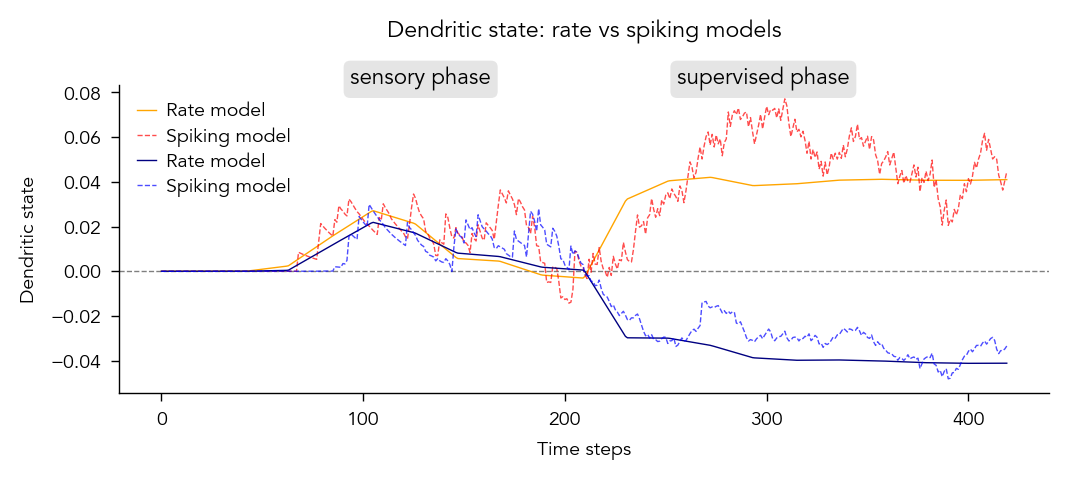

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6, 2))
ax.axhline(0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
dendritic_state_expanded = torch.tensor(scipy.ndimage.zoom(dendritic_state[:, positive_unit_idx], time_coefficient, order=1))
ax.plot(dendritic_state_expanded, color='orange', label='Rate model')
ax.plot(dend_voltage_trace['positive_unit'], color='r', label='Spiking model', linestyle='--', alpha=0.7)
dendritic_state_expanded = torch.tensor(scipy.ndimage.zoom(dendritic_state[:, negative_unit_idx], time_coefficient, order=1))
ax.plot(dendritic_state_expanded, color='navy', label='Rate model')
ax.plot(dend_voltage_trace['negative_unit'], color='b', label='Spiking model', linestyle='--', alpha=0.7)

ax.text(0.4, 1, 'sensory phase', transform=ax.transAxes, ha='right', fontsize=8, bbox=dict(facecolor='gray', alpha=0.2, boxstyle='round,pad=0.3', linewidth=0))
ax.text(0.6, 1, 'supervised phase', transform=ax.transAxes, ha='left', fontsize=8, bbox=dict(facecolor='gray', alpha=0.2, boxstyle='round,pad=0.3', linewidth=0))
ax.set_title(f"Dendritic state: rate vs spiking models", y=1.1)

ax.set_xlabel('Time steps')
ax.set_ylabel('Dendritic state')
ax.legend()
plt.show()

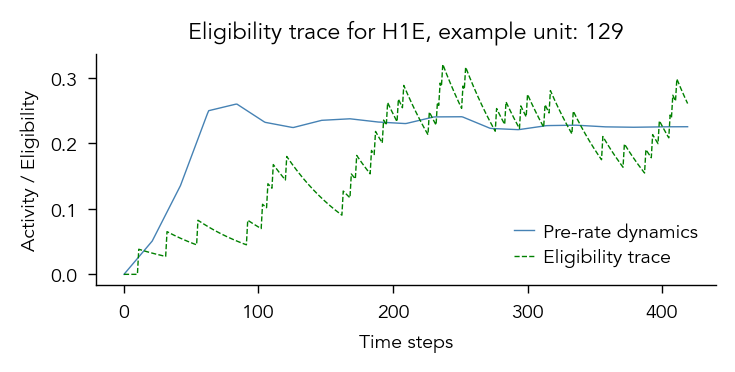

In [9]:
pre_unit_idx = 129
rate_dynamics = torch.tensor(scipy.ndimage.zoom(activity_dynamics_dict['H1E'][:, pre_unit_idx], time_coefficient, order=1))
plt.plot(rate_dynamics, label='Pre-rate dynamics', color='steelblue')
plt.plot(eligibility_traces['H1E'][:, pre_unit_idx], label='Eligibility trace', color='green', linestyle='--')
plt.title(f"Eligibility trace for H1E, example unit: {pre_unit_idx}")
plt.xlabel('Time steps')
plt.ylabel('Activity / Eligibility')
plt.legend()
plt.show()

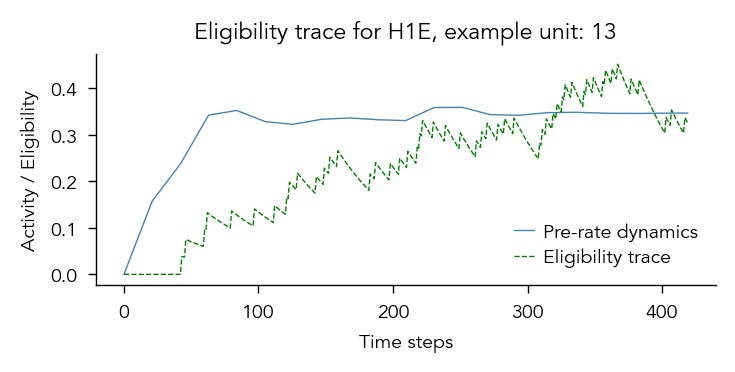

In [10]:
pre_unit_idx = 13
rate_dynamics = torch.tensor(scipy.ndimage.zoom(activity_dynamics_dict['H1E'][:, pre_unit_idx], time_coefficient, order=1))
plt.plot(rate_dynamics, label='Pre-rate dynamics', color='steelblue')
plt.plot(eligibility_traces['H1E'][:, pre_unit_idx], label='Eligibility trace', color='green', linestyle='--')
plt.title(f"Eligibility trace for H1E, example unit: {pre_unit_idx}")
plt.xlabel('Time steps')
plt.ylabel('Activity / Eligibility')
plt.legend()
plt.show()